[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aurelio-labs/langchain-course/blob/main/chapters/01-intro.ipynb)

#### LangChain Essentials Course

# Getting Started with LangChain

LangChain is one of the most popular open source libraries for AI Engineers. It's goal is to abstract away the complexity in building AI software, provide easy-to-use building blocks, and make it easier when switching between AI service providers.

In this example, we will introduce LangChain, building a simple LLM-powered assistant. We'll provide examples for both OpenAI's `gpt-4o-mini` *and* Meta's `llama3.2` via Ollama!

---

> ⚠️ We will be using OpenAI for this example allowing us to run everything via API. If you would like to use Ollama instead, check out the [Ollama LangChain Course](https://github.com/aurelio-labs/langchain-course/tree/main/notebooks/ollama).

---

In [132]:
# REMOVED THE SPECIFIC VERSION
# I was getting issues when initializing the LLMs

!pip install -qU \
    langchain-core \
    langchain-openai \
    langchain-community



## Initializing OpenAI's gpt-4o-mini

We start by initializing our LLM. We will use OpenAI's `gpt-4o-mini` model, if you need an API key you can get one from [OpenAI's website](https://platform.openai.com/settings/organization/api-keys).

In [133]:
import os
from google.colab import userdata
# GET KEY FROM COLAB ENV
openai_api_key = userdata.get("OPENAI_API_KEY")
if openai_api_key:
  os.environ["OPENAI_API_KEY"] = openai_api_key
  print("OPENAI_API_KEY IS PRESENT")
else:
  raise ValueError("OPENAI_API_KEY is missing or empty")

# SET MODEL
openai_model = "gpt-4o-mini"

OPENAI_API_KEY IS PRESENT


In [134]:
from langchain_openai import ChatOpenAI

# For normal accurate responses based on the tempature settings
llm = ChatOpenAI(temperature=0.0, model=openai_model)

# For unique creative responses based on the tempature settings
creative_llm = ChatOpenAI(temperature=0.9, model=openai_model)

We will be taking an `article` _draft_ and using LangChain to generate various useful items around this article. We'll be creating:

1. An article title
2. An article description
3. Editor advice where we will insert an additional paragraph in the article
4. A thumbnail / hero image for our article.

Here we input our article to start with. Currently this is using an article from the Aurelio AI learning page.

In [135]:
# INSTALL MARKDOWNIFY to Create Article content form website
#!pip install markdownify requests
import requests
from markdownify import markdownify as md
import textwrap

# Fetch the webpage
url = "https://code.shawngoodin.com/"
response = requests.get(url)

# Convert to markdown with options
markdown_content = md(
    response.text,
    heading_style="ATX",  # Use # for headings
    code_language_callback=lambda el: el.get('class')[0].split('-')[1] if el.get('class') else '',
    strip=['script', 'style'],  # Remove script and style tags
    keep_inline_images=True
)

# Pass to your LangChain application
article = markdown_content
import textwrap
wrapped_text = textwrap.fill(article, width=180)
#print(wrapped_text)

## Preparing our Prompts

LangChain comes with several prompt classes and methods for organizing or constructing our prompts. We will cover these in more detail in later examples, but for now we'll cover the essentials that we need here.

Prompts for chat agents are at a minimum broken up into three components, those are:

* System prompt: this provides the instructions to our LLM on how it must behave, what it's objective is, etc.

* User prompt: this is a user written input.

* AI prompt: this is the AI generated output. When representing a conversation, previous generations will be inserted back into the next prompt and become part of the broader _chat history_.

```
You are a helpful AI assistant, you will do XYZ.    | SYSTEM PROMPT

User: Hi, what is the capital of Australia?         | USER PROMPT
AI: It is Canberra                                  | AI PROMPT
User: When is the best time to visit?               | USER PROMPT
```

LangChain provides us with _templates_ for each of these prompt types. By using templates we can insert different inputs to the template, modifying the prompt based on the provided inputs.

Let's initialize our system and user prompt first:

In [150]:
from langchain.prompts import SystemMessagePromptTemplate, HumanMessagePromptTemplate

# Defining the system prompt (how the AI should act)
system_prompt = SystemMessagePromptTemplate.from_template(
    """You are an AI assistant called {name} that helps generate article titles.""",
    input_variables=["name"]
)

# the user prompt is provided by the user, in this case however the only dynamic
# input is the article
user_prompt = HumanMessagePromptTemplate.from_template(
    """You are tasked with creating a name for a article.
The article is here for you to examine {article}

The name should be based of the context of the article.
Be creative, but make sure the names are clear, catchy,
and relevant to the theme of the article.

Only output the article name, no other explanation or
text can be provided.""",
    input_variables=["article"]
)

We can display what our formatted human prompt would look like after inserting a value into the `article` parameter:

In [151]:
user_prompt.format(article="TEST STRING")

HumanMessage(content='You are tasked with creating a name for a article.\nThe article is here for you to examine TEST STRING\n\nThe name should be based of the context of the article.\nBe creative, but make sure the names are clear, catchy,\nand relevant to the theme of the article.\n\nOnly output the article name, no other explanation or\ntext can be provided.', additional_kwargs={}, response_metadata={})

We have our system and user prompts, we can merge both into our full chat prompt using the `ChatPromptTemplate`:

In [152]:
from langchain.prompts import ChatPromptTemplate

first_prompt = ChatPromptTemplate.from_messages([system_prompt, user_prompt])

By default, the `ChatPromptTemplate` will read the `input_variables` from each of the prompt templates inserted and allow us to use those input variables when formatting the full chat prompt template:

In [165]:
print(first_prompt.format(
  name="Joe",
  article="TEST STRING"
))

System: You are an AI assistant called Joe that helps generate article titles.
Human: You are tasked with creating a name for a article.
The article is here for you to examine TEST STRING

The name should be based of the context of the article.
Be creative, but make sure the names are clear, catchy,
and relevant to the theme of the article.

Only output the article name, no other explanation or
text can be provided.


`ChatPromptTemplate` also prefixes each individual message with it's role, ie `System:`, `Human:`, or `AI:`.

We can chain together our `first_prompt` template and the `llm` object we defined earlier to create a simple LLM chain. This chain will perform the steps **prompt formatting > llm generation > get output**.

We'll be using **L**ang**C**hain **E**xpression **L**anguage (LCEL) to construct our chain. This syntax can look a little strange but we will cover it in detail later in the course. For now, all we need to know is that we define our inputs with the first dictionary segment (ie `{"article": lambda x: x["article"]}`) and then we use the pipe operator (`|`) to say that the output from the left of the pipe will be fed into the input to the right of the pipe.

In [166]:
chain_one = (
    {"article": lambda x: x["article"],
     "name": lambda x: x["name"]
     }
    | first_prompt
    | creative_llm
    | {"article_title": lambda x: x.content}
)

Our first chain creates the article title, note: we can run all of these individually...

In [171]:
article_title_msg = chain_one.invoke({
    "article": article,
    "name": "Grok"
    })
article_title_msg

{'article_title': '"Unveiling AI\'s Cognitive Spectrum: The REACT Framework Revolution"'}

But we will actually chain this step with multiple other `LLMChain` steps. So, to continue, our next step is to summarize the article using both the `article` and newly generated `article_title` values, from which we will output a new `summary` variable:

In [172]:
second_user_prompt = HumanMessagePromptTemplate.from_template(
    """You are tasked with creating a description for
the article. The article is here for you to examine:

---

{article}

---

Here is the article title '{article_title}'.

Output the SEO friendly article description. Do not output
anything other than the description.""",
    input_variables=["article", "article_title"]
)

second_prompt = ChatPromptTemplate.from_messages([
    system_prompt,
    second_user_prompt
])

In [180]:
chain_two = (
    {
        "article": lambda x: x["article"],
        "article_title": lambda x: x["article_title"],
        "name": lambda x: x["name"]
    }
    | second_prompt
    | llm
    | {"summary": lambda x: x.content}
)


In [181]:
article_description_msg = chain_two.invoke({
    "article": article,
    "article_title": article_title_msg["article_title"],
    "name": "Grok"
})
article_description_msg

{'summary': 'Discover the REACT AI Intelligence framework, a groundbreaking approach to categorizing and assessing artificial intelligence systems based on their cognitive capabilities. This article explores how REACT fills critical gaps in existing AI frameworks by focusing on the quality and sophistication of AI reasoning. Learn about the five progressive levels of cognitive intelligence—Recognition, Evaluation, Analysis, Correlation, and Thinking—and how they provide a multidimensional perspective on AI maturity. Ideal for researchers, developers, and organizations, the REACT framework offers valuable insights for understanding, advancing, and responsibly implementing AI technologies.'}

The third step will consume our first `article` variable and provide several output fields, focusing on helping the user improve a part of their writing. As we are outputting multiple fields we can specify for the LLM to use structured outputs, keeping the generated fields aligned with our requirements.

In [57]:
third_user_prompt = HumanMessagePromptTemplate.from_template(
    """You are tasked with creating a new paragraph for the
article. The article is here for you to examine:

---

{article}

---

Choose one paragraph to review and edit. During your edit
ensure you provide constructive feedback to the user so they
can learn where to improve their own writing.""",
    input_variables=["article"]
)

# prompt template 3: creating a new paragraph for the article
third_prompt = ChatPromptTemplate.from_messages([
    system_prompt,
    third_user_prompt
])

We create a pydantic object describing the output format we need. This format description is then passed to our model using the `with_structured_output` method:

In [182]:
from pydantic import BaseModel, Field

class Paragraph(BaseModel):
    original_paragraph: str = Field(description="The original paragraph")
    edited_paragraph: str = Field(description="The improved edited paragraph")
    feedback: str = Field(description=(
        "Constructive feedback on the original paragraph"
    ))

structured_llm = creative_llm.with_structured_output(Paragraph)

Now we put all of this together in another chain:

In [183]:
# chain 3: inputs: article / output: article_para
chain_three = (
    {"article": lambda x: x["article"]}
    | third_prompt
    | structured_llm
    | {
        "original_paragraph": lambda x: x.original_paragraph,
        "edited_paragraph": lambda x: x.edited_paragraph,
        "feedback": lambda x: x.feedback
    }
)

In [184]:
out = chain_three.invoke({"article": article})
out

{'original_paragraph': 'While existing AI frameworks primarily focus on autonomy and human-AI collaboration, REACT addresses a critical gap by examining the quality and sophistication of AI reasoning itself. By providing a cognitive perspective on AI maturity, REACT offers researchers, developers, and organizations a valuable tool for understanding, assessing, and advancing AI intelligence in a thoughtful, strategic, and responsible manner.',
 'edited_paragraph': 'Unlike existing AI frameworks that concentrate mainly on autonomy and human-AI collaboration, the REACT framework fills a critical void by examining the quality and sophistication of AI reasoning. This unique cognitive perspective on AI maturity equips researchers, developers, and organizations with a valuable tool for understanding, assessing, and advancing AI intelligence strategically and responsibly.',
 'feedback': "The original paragraph provides a clear statement of the REACT framework's purpose, but it could benefit fr

Now we want this article to look appealing, so we need to grab an image based of our article! However the prompt for the article image `cannot be over 1000 letters` so this has to be short in case we want to add anything in such as `style` later on.

In [185]:
from langchain_community.utilities.dalle_image_generator import DallEAPIWrapper
from langchain_core.prompts import PromptTemplate


image_prompt = PromptTemplate(
    input_variables=["article"],
    template=(
        "Generate a prompt with less then 500 characters to generate an image "
        "based on the following article: {article}"
    )
)

In [186]:
from openai import OpenAI
from langchain_core.runnables import RunnableLambda
from langchain_core.prompts import PromptTemplate
import matplotlib.pyplot as plt
import requests
import base64
import time
from io import BytesIO
from PIL import Image
from IPython.display import display, Image as IPImage

# Initialize OpenAI client
client = OpenAI(api_key=openai_api_key)

# Your existing prompt template
image_prompt = PromptTemplate(
    input_variables=["article"],
    template=(
        "Generate a prompt with less than 500 characters to generate an image "
        "based on the following article: {article}"
    )
)



The `generate_and_display` function will generate the article image once we have the prompt from our image prompt.

In [188]:
def generate_and_display_image(image_prompt):
  # Use DALL-E 3 for image generation
  img = client.images.generate(
      model="gpt-image-1",
      prompt=image_prompt,
      background="auto",
      n=1,
      size="1536x1024",
      quality="medium",
      output_format="png",
      moderation="auto"
      )

  # Save the image into a file
  image_bytes = base64.b64decode(img.data[0].b64_json)
  img_path = f"output_{int(time.time())}.png"
  with open(img_path, "wb") as f:
    f.write(image_bytes)

    print(f"Image saved to {img_path}")

    display(IPImage(filename=img_path))

    return img_path



We have all of our image generation components ready, we chain them together again with LCEL:

In [189]:
# chain 4: inputs: article, article_para / outputs: new_suggestion_article
# Wrap in RunnableLambda
image_gen_runnable = RunnableLambda(generate_and_display_image)

# Your chain remains the same
chain_four = (
    {"article": lambda x: x["article"]}
    | image_prompt
    | llm
    | (lambda x: x.content)
    | image_gen_runnable
)

And now, we `invoke` our final chain:

Image saved to output_1746420053.png


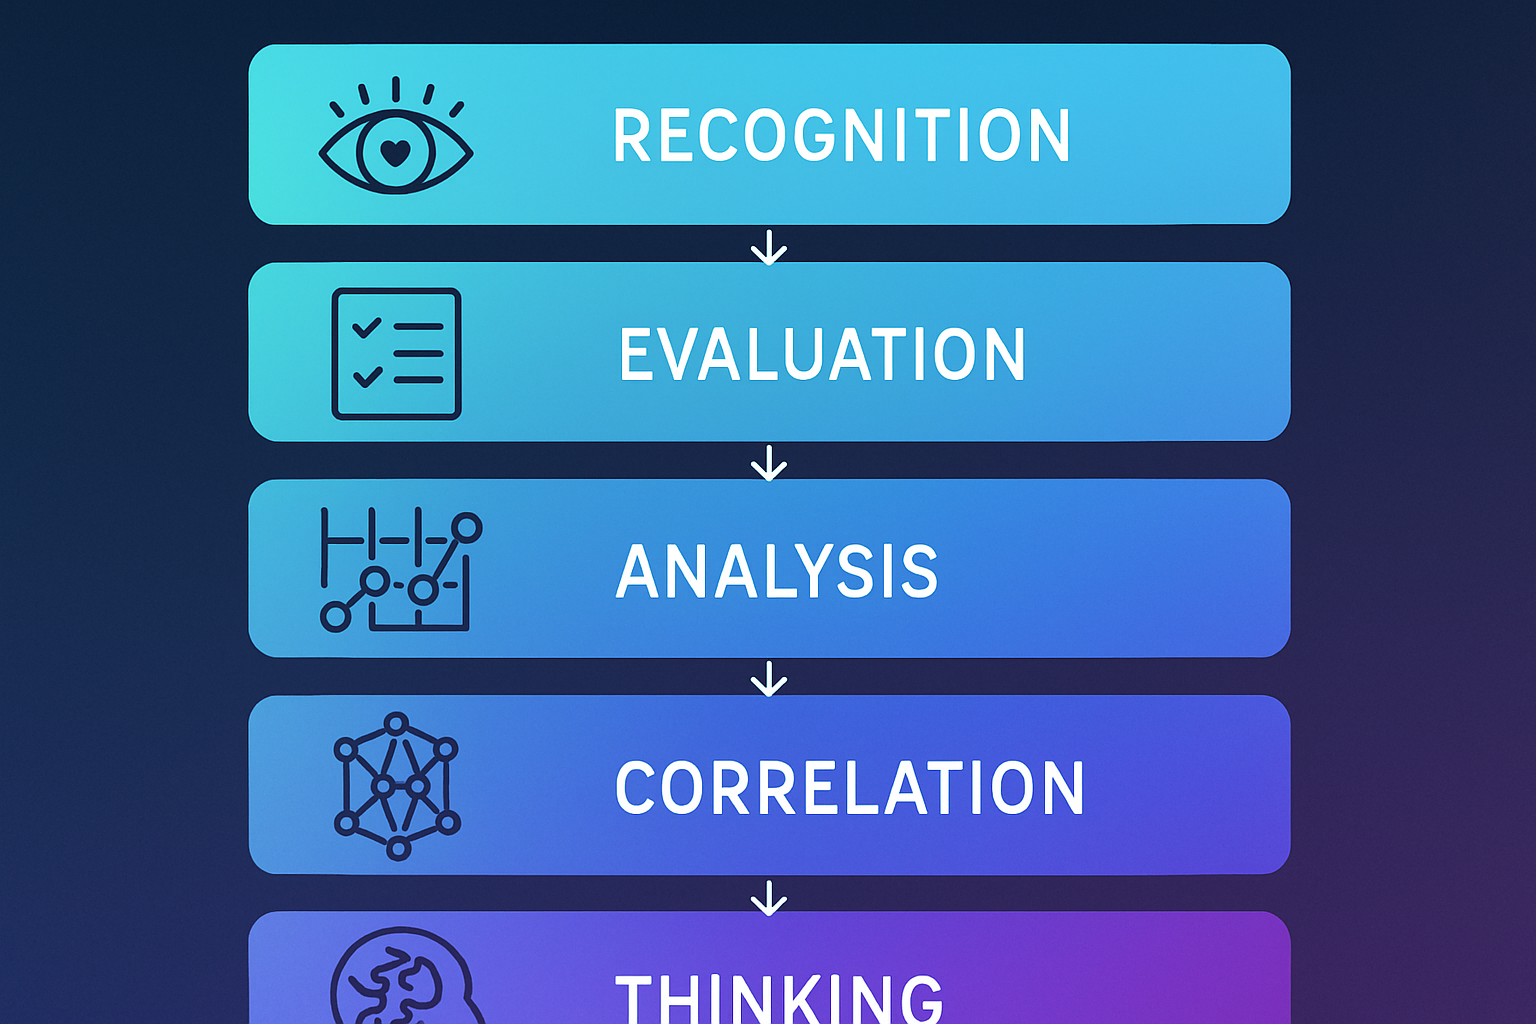

'output_1746420053.png'

In [190]:
chain_four.invoke({"article": article})

With that we've built LLM chains that can help us building and writing articles. We've understood a few of the basics of LangChain, introduced **L**ang**C**hain **E**xpression **L**anguage (LCEL), and built a multi-modal article-helper pipeline.